In [6]:
!pip install pyspark
!pip install faker
!pip install kaleido
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, TimestampType
import numpy as np
from faker import Faker
from datetime import timedelta
import random
spark = SparkSession.builder.appName("TripDataGeneration").getOrCreate()
fake = Faker()


In [7]:
schema = StructType([
    StructField("TripID", IntegerType(), False),
    StructField("StartTime", TimestampType(), False),
    StructField("EndTime", TimestampType(), False),
    StructField("Distance", FloatType(), False),
    StructField("Fare", FloatType(), False)
])

In [20]:

num_records = 1_000_000
rdd = spark.sparkContext.parallelize(range(num_records)).map(
    lambda i: (i,fake.date_time_between(start_date="-2d", end_date="now"), random.randint(5, 120),  # Duration (generated inside map)
        round(random.uniform(1, 50), 2),  # Distance
    )
)

rdd = rdd.map(lambda x: (
    x[0],x[1], x[1] + timedelta(minutes=x[2]),x[3],
    round(x[3] * random.uniform(5, 15), 2)
))

df = spark.createDataFrame(rdd, schema=schema)
df.show(5)


+------+--------------------+--------------------+--------+------+
|TripID|           StartTime|             EndTime|Distance|  Fare|
+------+--------------------+--------------------+--------+------+
|     0|2025-03-07 03:17:...|2025-03-07 04:35:...|     5.2| 53.62|
|     1|2025-03-06 09:02:...|2025-03-06 10:21:...|   43.87|584.25|
|     2|2025-03-06 18:05:...|2025-03-06 18:29:...|   40.16|558.12|
|     3|2025-03-06 18:20:...|2025-03-06 19:09:...|   24.38|277.73|
|     4|2025-03-06 12:48:...|2025-03-06 14:36:...|   43.35|431.08|
+------+--------------------+--------------------+--------+------+
only showing top 5 rows



In [9]:
from pyspark.sql import functions as F
df = df.withColumn("TripDuration", (F.unix_timestamp(F.col("EndTime")) - F.unix_timestamp(F.col("StartTime"))) / 60)
df.show(5)


+------+--------------------+--------------------+--------+------+------------+
|TripID|           StartTime|             EndTime|Distance|  Fare|TripDuration|
+------+--------------------+--------------------+--------+------+------------+
|     0|2025-03-07 03:10:...|2025-03-07 03:18:...|   35.78|241.41|         8.0|
|     1|2025-03-06 08:55:...|2025-03-06 09:31:...|   21.87|223.85|        36.0|
|     2|2025-03-06 17:58:...|2025-03-06 18:29:...|   35.23| 410.3|        31.0|
|     3|2025-03-06 18:13:...|2025-03-06 18:41:...|   32.76|442.31|        28.0|
|     4|2025-03-06 12:41:...|2025-03-06 14:11:...|   20.16|180.72|        90.0|
+------+--------------------+--------------------+--------+------+------------+
only showing top 5 rows



In [10]:
df_p = df.select((F.col("Fare") / F.col("Distance")).alias("FarePerMile"))
df_p.show(5)



+------------------+
|       FarePerMile|
+------------------+
| 9.922096709500302|
| 6.871533871098768|
| 8.023837537551636|
|  5.85667827568234|
|10.308865994481504|
+------------------+
only showing top 5 rows



In [11]:
Longest=df.select('TripDuration').orderBy(F.col('TripDuration').desc()).limit(3)
Longest.show()

+------------+
|TripDuration|
+------------+
|       120.0|
|       120.0|
|       120.0|
+------------+



In [12]:
LongestByDistance = df.select('TripID', 'Distance', 'TripDuration').orderBy(F.col('Distance').desc()).limit(3)
LongestByDistance.show()


+------+--------+------------+
|TripID|Distance|TripDuration|
+------+--------+------------+
|511304|    50.0|        96.0|
| 20003|    50.0|        27.0|
|539239|    50.0|        60.0|
+------+--------+------------+



In [13]:

trips_per_hour = df.withColumn("HourOfDay", F.hour(F.col("StartTime"))) .groupBy("HourOfDay") .agg(F.count("TripID").alias("TotalTrips"))
trips_per_hour.show(5)


+---------+----------+
|HourOfDay|TotalTrips|
+---------+----------+
|       12|     41214|
|       22|     41920|
|        1|     41908|
|       13|     41125|
|        6|     41731|
+---------+----------+
only showing top 5 rows



In [17]:
import plotly.express as px
import plotly.graph_objects as go
trips_per_hour_pd = trips_per_hour.toPandas()
trips_per_hour_pd = trips_per_hour_pd.sort_values(by="HourOfDay")
trips_per_hour_pd = trips_per_hour_pd.groupby("HourOfDay", as_index=False).sum()
trips_per_hour_pd["HourOfDay"] = trips_per_hour_pd["HourOfDay"].astype(int)
fig1 = px.line(trips_per_hour_pd,x="HourOfDay",y="TotalTrips",  title="Trips Per Hour (Line Chart with Peaks & Lows)",labels={"HourOfDay": "Hour of Day", "TotalTrips": "Total Number of Trips"},
               markers=True,color_discrete_sequence=["blue"])
max_point = trips_per_hour_pd.loc[trips_per_hour_pd["TotalTrips"].idxmax()]
min_point = trips_per_hour_pd.loc[trips_per_hour_pd["TotalTrips"].idxmin()]
fig1.add_trace(go.Scatter(x=[max_point["HourOfDay"]],y=[max_point["TotalTrips"]],mode='markers+text',text=["Peak"],textposition="top center",marker=dict(color='red', size=12, symbol='star')
))

fig1.add_trace(go.Scatter( x=[min_point["HourOfDay"]], y=[min_point["TotalTrips"]], mode='markers+text', text=["Low"], textposition="bottom center", marker=dict(color='green', size=12, symbol='diamond')
))


fig1.show()


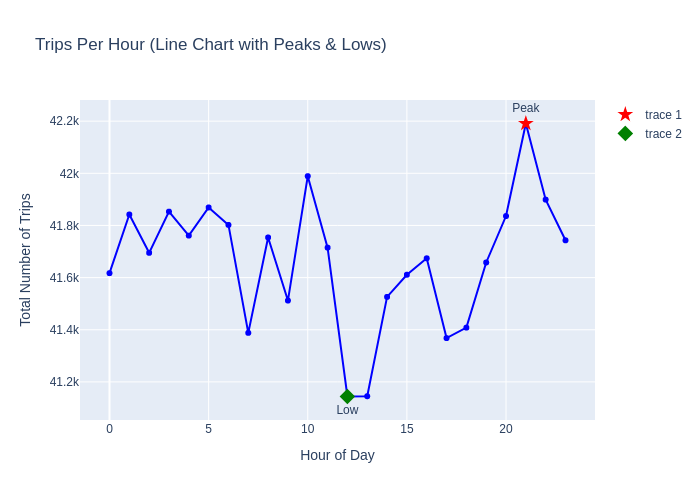

In [18]:
fig1.write_image("trips_per_hour_line_chart.png")

from IPython.display import display, Image
display(Image(filename="trips_per_hour_line_chart.png"))


